In [1]:
import numpy as np
import math
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
import classical_newsvendor_utils

from os import listdir
from os.path import isfile, join

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

import joblib

In [2]:
scaler = joblib.load('scaler.gz')

tmean = torch.tensor(scaler.mean_.item())
tstd = torch.tensor(scaler.scale_.item())

In [3]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [4]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [5]:
noise_type = 'gaussian'

In [6]:
N_test = 1800

X, y = data_generator.data_1to1(N_test, noise_level=1, noise_type=noise_type, uniform_input_space=True)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
models_path = './models/'
csvs_path = './newsvendor_results/'
csv_names = [f for f in listdir(csvs_path) if (isfile(join(csvs_path, f)) and noise_type in f)]

In [8]:
df_results = pd.DataFrame()

for cn in csv_names:
    csv_name = cn
    model_name = cn.replace('csv','pkl')

    df_aux = pd.read_csv(csvs_path+csv_name)
    df_aux = df_aux.set_index('Unnamed: 0')
    df_aux.columns = [csv_name]
    
    df_results = pd.concat([df_results, df_aux], axis=1)

In [26]:
df_results['bnngaussian1128512_nr.csv'].loc[0.1]

0.308

In [10]:
model_name_ann_dec = "ann0.0_multimodal.pkl"
model_name_ann_com02 = "ann_combined_q0.2_multimodal.pkl"
model_name_ann_com08 = "ann_combined_q0.8_multimodal.pkl"

model_name_bnn_dec = "bnn0.0_gaussian_16_100.pkl"
model_name_bnn_com02 = "bnn_combined_q0.2_multimodal.pkl"
model_name_bnn_com08 = "bnn_combined_q0.8_multimodal.pkl"

model_name_flow = "flow_multimodal.pkl"
model_name_flow_com02 = "flow_combined_q0.2_multimodal.pkl"
model_name_flow_com08 = "flow_combined_q0.8_multimodal.pkl"

In [9]:
model_name_ann_dec = "ann_gaussian_16_100.pkl"
model_name_ann_com02 = "ann_combined_q0.2_gaussian.pkl"
model_name_ann_com08 = "ann_combined_q0.8_gaussian.pkl"

model_name_bnn_dec = "bnn_gaussian_0_1_2_64.pkl"
model_name_bnn_com02 = "bnn_combined_q0.2_gaussian.pkl"
model_name_bnn_com08 = "bnn_combined_q0.8_gaussian.pkl"

model_name_flow = "flow_gaussian.pkl"
model_name_flow_com02 = "flow_combined_q0.2_gaussian.pkl"
model_name_flow_com08 = "flow_combined_q0.8_gaussian.pkl"

In [20]:
model_name_ann_dec_model = torch.load(f'./models/{model_name_ann_dec}')
model_name_ann_com02_model = torch.load(f'./models/{model_name_ann_com02}')
#model_name_ann_com08_model = torch.load(f'./models/{model_name_ann_com08}')

model_name_bnn_dec_model = torch.load(f'./models/{model_name_bnn_dec}')
model_name_bnn_com02_model = torch.load(f'./models/{model_name_bnn_com02}')
#model_name_bnn_com08_model = torch.load(f'./models/{model_name_bnn_com08}')

model_flow = torch.load(f'./models/{model_name_flow}')
model_flow_com02 = torch.load(f'./models/{model_name_flow_com02}')
#model_flow_com08 = torch.load(f'./models/{model_name_flow_com08}')

In [21]:
#model_mse.update_n_samples(1000)
model_name_bnn_dec_model.update_n_samples(200)
model_name_bnn_com02_model.update_n_samples(200)
#odel_name_bnn_com08_model.update_n_samples(200)

In [22]:
xt = torch.tensor(np.arange(-4.0, 4.0, 1/800), dtype = torch.float32)

In [15]:
y_pred_ann_dec = model_name_ann_dec_model.forward_dist(xt.unsqueeze(1))

AttributeError: 'StandardNet' object has no attribute 'linear4'

In [23]:
y_pred_bnn_dec = model_name_bnn_dec_model.forward_dist(xt.unsqueeze(1), aleat_bool=True)
#y_pred_bnn_com02 = model_name_bnn_com02_model.forward_dist(xt.unsqueeze(1))
#y_pred_bnn_com08 = model_name_bnn_com08_model.forward_dist(xt.unsqueeze(1))

In [75]:
M = 1000
N = xt.shape[0]

y_pred_flow = torch.zeros((M, N))
for i in range(0, N):
    y_pred_flow[:,i] = model_flow.condition(xt.unsqueeze(1)[i]).sample(torch.Size([M,])).squeeze()
    
y_pred_flow_c02 = torch.zeros((M, N))
for i in range(0, N):
    y_pred_flow_c02[:,i] = model_flow_com02.condition(xt.unsqueeze(1)[i]).sample(torch.Size([M,])).squeeze()
    
#y_pred_flow_c08 = torch.zeros((M, N))
#for i in range(0, N):
#    y_pred_flow_c08[:,i] = model_flow_com08.condition(xt.unsqueeze(1)[i]).sample(torch.Size([M,])).squeeze()

In [16]:
y_pred_ann_dec = model_name_ann_dec_model(xt.unsqueeze(1))
y_pred_ann_com02 = model_name_ann_com02_model(xt.unsqueeze(1))
#y_pred_ann_com08 = model_name_ann_com08_model(xt.unsqueeze(1))

AttributeError: 'StandardNet' object has no attribute 'linear3_2'

In [24]:
def inverse_transform(y):
    return y*tstd + tmean

In [18]:
print(F.mse_loss(inverse_transform(model_name_ann_dec_model(X)), y))
print(F.mse_loss(inverse_transform(model_name_ann_com02_model(X)), y))
#print(F.mse_loss(inverse_transform(model_name_ann_com08_model(X)), y))

TypeError: only integer tensors of a single element can be converted to an index

In [19]:
print(F.mse_loss(inverse_transform(model_name_bnn_dec_model.forward_dist(X).mean(0)), y))
print(F.mse_loss(inverse_transform(model_name_bnn_com02_model(X).mean(0)), y))
#print(F.mse_loss(inverse_transform(model_name_bnn_com08_model(X).mean(0)), y))

tensor(19.2149, grad_fn=<MseLossBackward0>)


AttributeError: 'VariationalLayer' object has no attribute 'dev'

In [63]:
M = 1000
N = X.shape[0]

y_pred_flow_X = torch.zeros((M, N))
for i in range(0, N):
    y_pred_flow_X[:,i] = model_flow.condition(X[i]).sample(torch.Size([M,])).squeeze()
    
y_pred_flow_X_c02 = torch.zeros((M, N))
for i in range(0, N):
    y_pred_flow_X_c02[:,i] = model_flow_com02.condition(X[i]).sample(torch.Size([M,])).squeeze()
    
#y_pred_flow_X_c08 = torch.zeros((M, N))
#for i in range(0, N):
#    y_pred_flow_X_c08[:,i] = model_flow_com08.condition(X[i]).sample(torch.Size([M,])).squeeze()

print(F.mse_loss(inverse_transform(y_pred_flow_X).mean(0).unsqueeze(1), y))
print(F.mse_loss(inverse_transform(y_pred_flow_X_c02).mean(0).unsqueeze(1), y))
#print(F.mse_loss(inverse_transform(y_pred_flow_X_c08).mean(0).unsqueeze(1), y))

tensor(4.5809)
tensor(13.2178)


In [64]:
inverse_transform(model_name_ann_dec_model(X)).shape

torch.Size([3000, 1])

In [65]:
inverse_transform(model_name_bnn_dec_model(X).mean(0))

tensor([[ 2.8514],
        [ 3.9041],
        [ 0.7475],
        ...,
        [11.4230],
        [ 4.5139],
        [ 4.1003]], grad_fn=<AddBackward0>)

In [18]:
y_pred_ann_dec_orig = inverse_transform(y_pred_ann_dec)
y_pred_bnn_dec_orig = inverse_transform(y_pred_bnn_dec)

In [23]:
y_pred_ann_dec_orig = inverse_transform(y_pred_ann_dec)
y_pred_ann_com02_orig = inverse_transform(y_pred_ann_com02)
#y_pred_ann_com08_orig = inverse_transform(y_pred_ann_com08)

y_pred_bnn_dec_orig = inverse_transform(y_pred_bnn_dec)
y_pred_bnn_com02_orig = inverse_transform(y_pred_bnn_com02)
#y_pred_bnn_com08_orig = inverse_transform(y_pred_bnn_com08)

y_pred_flow_orig = inverse_transform(y_pred_flow)
y_pred_flow_com02_orig = inverse_transform(y_pred_flow_c02)
#y_pred_flow_com08_orig = inverse_transform(y_pred_flow_c08)

NameError: name 'y_pred_ann_dec' is not defined

In [26]:
def plot_regression(X, y, xt, y_pred, method, suffix, color_pred, noise_type):

    y_pred_np = y_pred.squeeze().detach().numpy()
    y_np = y.detach().numpy()
    
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    
    #if method in ['BNN', 'FLOW']:        
    for i in range(0, len(y_pred_np)):
        ax.scatter(xt.detach(), y_pred_np[i],
                    color=color_pred, alpha=0.01, s=0.5)
    ax.scatter(X[:,0].detach(), y_np, color='#004488', label='Groundtruth', s=8, alpha=0.2)

    #elif method in ['ANN']:
        #ax.scatter(X[:,0].detach(), y_np, color='#004488', label='Groundtruth', s=8, alpha=0.5)
        #ax.scatter(xt.unsqueeze(1).detach().numpy(), 
        #                y_pred_np, 
        #                color=color_pred, 
        #                alpha=0.8, 
        #                s=3)
         
    #else:
    #    print('Not a valid method')
    #    exit()
        
    
    ax.set_xlabel('Input')
    ax.set_ylabel('Output (Demand)')
    
    ax.set_ylim([-3,3])
    ax.set_ylim([-2,60])

    legend_elements = [Line2D([0], [0], color=color_pred, lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Groundtruth',
                          markerfacecolor='#004488', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    fig.savefig(f'./figures/regression_{method}_{suffix}_{noise_type}.png')

In [18]:
'#EE3377', '#CC3311', '#EE7733'

('#EE3377', '#CC3311', '#EE7733')

In [21]:
plot_regression(X, y, xt, y_pred_ann_dec_orig, 'ANN', 'Decoupled', '#EE3377', noise_type)

NameError: name 'y_pred_ann_dec_orig' is not defined

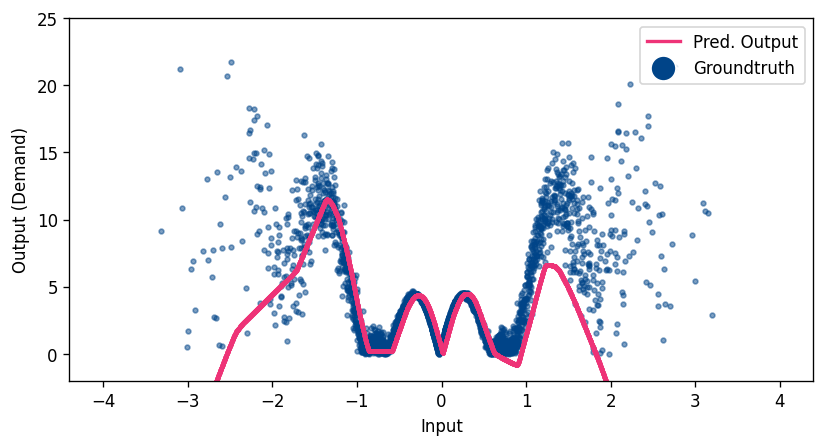

In [70]:
plot_regression(X, y, xt, y_pred_ann_com02_orig, 'ANN', 'Combined02', '#EE3377', noise_type)

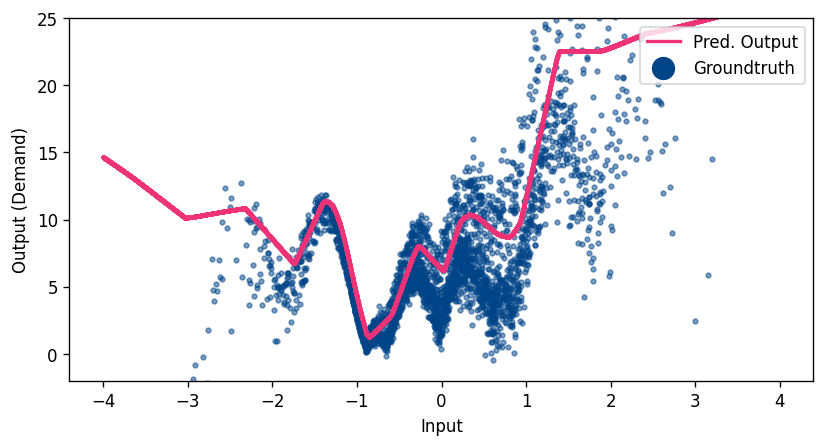

In [117]:
plot_regression(X, y, xt, y_pred_ann_com08_orig, 'ANN', 'Combined08', '#EE3377', noise_type)

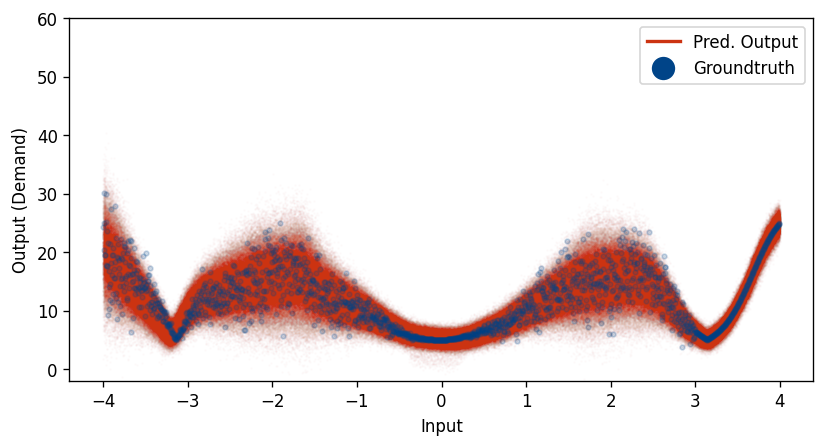

In [27]:
plot_regression(X, y, xt, y_pred_bnn_dec_orig, 'BNN', 'Decoupled', '#CC3311', noise_type)

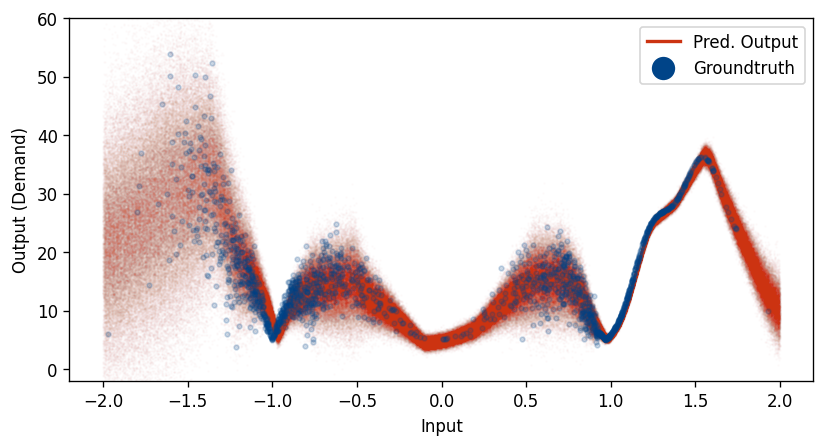

In [33]:
plot_regression(X, y, xt, y_pred_bnn_dec_orig, 'BNN', 'Decoupled', '#CC3311', noise_type)

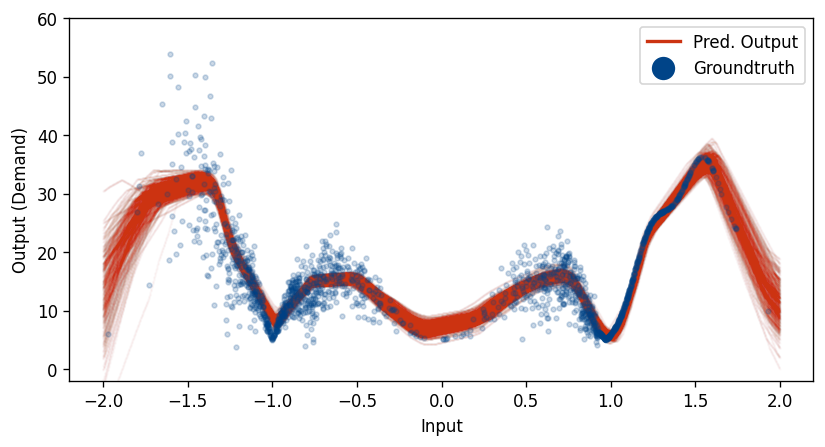

In [19]:
plot_regression(X, y, xt, y_pred_bnn_dec_orig, 'BNN', 'Decoupled', '#CC3311', noise_type)

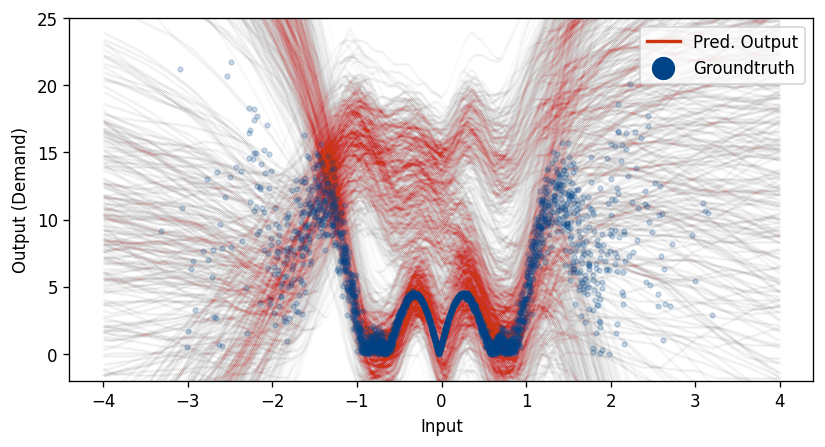

In [72]:
plot_regression(X, y, xt, y_pred_bnn_com02_orig, 'BNN', 'Combined02', '#CC3311', noise_type)

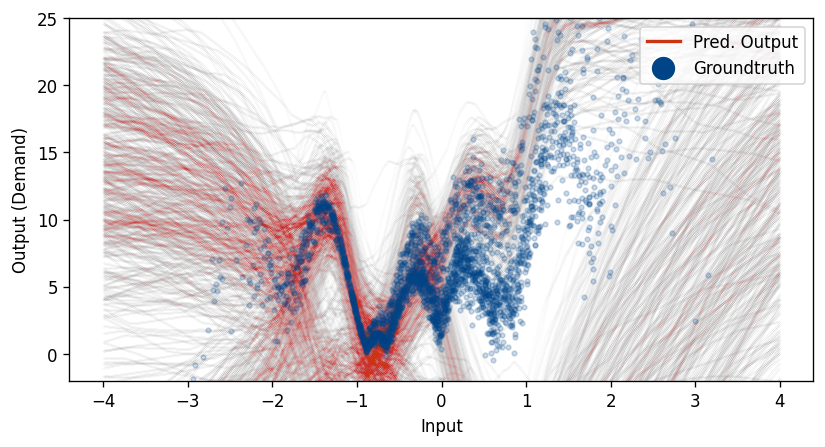

In [120]:
plot_regression(X, y, xt, y_pred_bnn_com08_orig, 'BNN', 'Combined08', '#CC3311', noise_type)

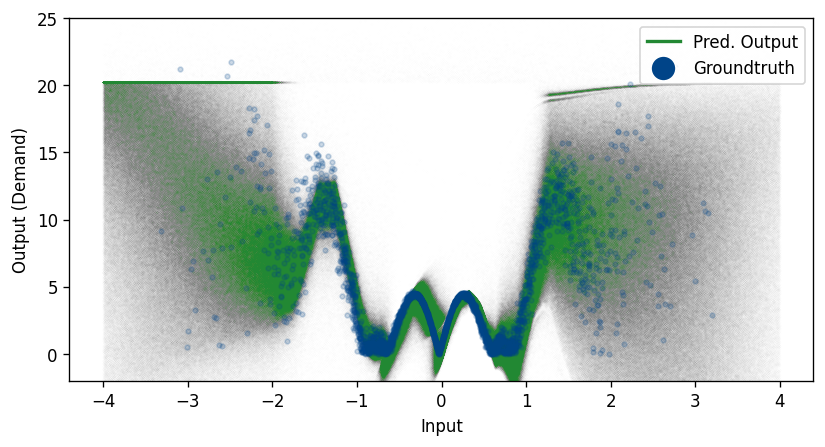

In [73]:
plot_regression(X, y, xt, y_pred_flow_orig, 'FLOW', 'Decoupled', '#228833', noise_type)

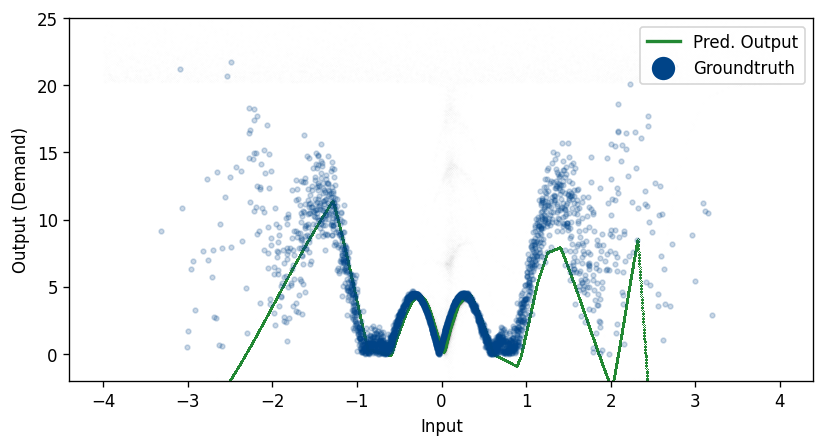

In [74]:
plot_regression(X, y, xt, y_pred_flow_com02_orig, 'FLOW', 'Combined02', '#228833', noise_type)

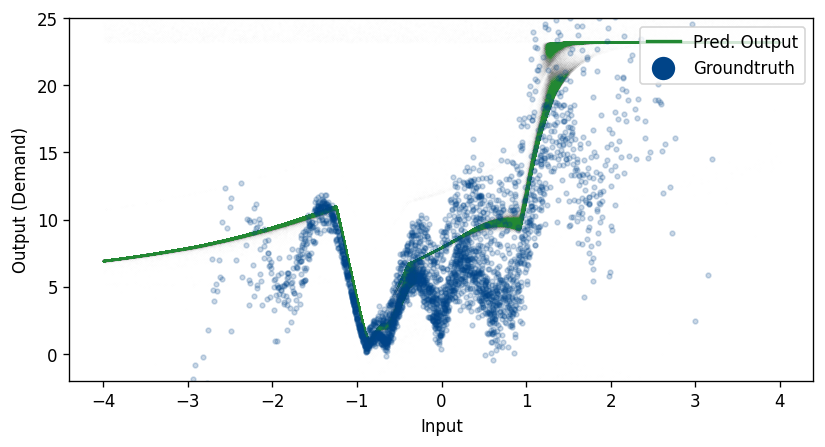

In [123]:
plot_regression(X, y, xt, y_pred_flow_com08_orig, 'FLOW', 'Combined08', '#228833', noise_type)

In [77]:
df_results[result_file_mse].keys().tolist()

NameError: name 'result_file_mse' is not defined

In [ ]:
'#EE3377', '#CC3311', '#EE7733'

def compute_nv_curve(X, y, model, M=1000):
    sell_price = 200
    dict_results_nr = {}
    for cost_price in (np.arange(0.1,0.9,0.03)*sell_price):
        quantile = (sell_price-cost_price)/sell_price
        dict_results_nr[quantile] = round(
            classical_newsvendor_utils.compute_norm_regret(
            X, y, model, M, sell_price, cost_price).item(), 
            3)
    return dict_results_nr

nr_ann = compute_nv_curve(X, y, model_mse, M=1000)
nr_ann_noise = compute_nv_curve(X, y, model_mse_noise, M=1000)
nr_bnn = compute_nv_curve(X, y, model_bnn_bayes, M=1000)

In [94]:
df_results = df_results.reset_index().sort_values(by='Unnamed: 0')

In [96]:
df_results

,Unnamed: 0,bnn5.0_gaussian_nr.csv,ann0.0_gaussian_nr.csv,bnn_combined_q0.2_gaussian_nr.csv,flow_gaussian_nr.csv,flow_combined_q0.2_gaussian_nr.csv,ann_combined_q0.2_gaussian_nr.csv
8,0.1,1.219,1.448,1.045,0.881,0.849,0.797
7,0.2,0.686,0.743,0.675,0.642,0.597,0.596
6,0.3,0.492,0.508,0.600,0.509,0.513,0.529
5,0.4,0.387,0.391,0.766,0.414,0.470,0.495
4,0.5,0.320,0.320,0.991,0.341,0.445,0.475
3,0.6,0.272,0.273,1.079,0.278,0.427,0.462
2,0.7,0.233,0.240,0.897,0.218,0.415,0.452
1,0.8,0.200,0.215,0.697,0.162,0.405,0.445
0,0.9,0.168,0.195,0.366,0.106,0.397,0.439


In [98]:
df_results['Unnamed: 0'].tolist()

8    0.1
7    0.2
6    0.3
5    0.4
4    0.5
3    0.6
2    0.7
1    0.8
0    0.9
Name: Unnamed: 0, dtype: float64

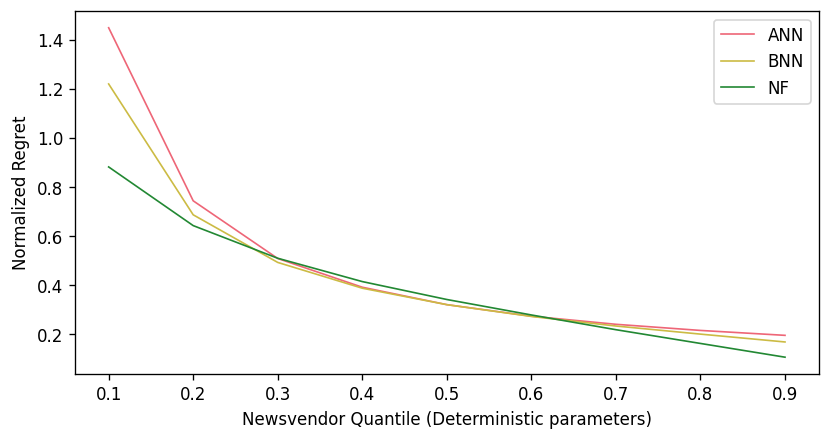

In [100]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.plot(df_results['Unnamed: 0'].tolist(), 
        df_results['ann0.0_gaussian_nr.csv'].tolist(), 
        color='#EE6677', label='ANN', linewidth=1)

ax.plot(df_results['Unnamed: 0'].tolist(), 
        df_results['bnn5.0_gaussian_nr.csv'].tolist(), 
        color='#CCBB44', label='BNN', linewidth=1)

ax.plot(df_results['Unnamed: 0'].tolist(), 
        df_results['flow_gaussian_nr.csv'].tolist(), 
        color='#228833', label='NF', linewidth=1)

ax.legend()

ax.set_ylabel('Normalized Regret')
ax.set_xlabel('Newsvendor Quantile (Deterministic parameters)')
fig.savefig('./figures/newsvendor_quantile_curve.png')